In [1]:
# imports
from sympy import diff, symbols, exp, Eq, solve, lambdify, simplify, expand, factor, Equality
from sympy.abc import t, s
import sympy

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

import json

# State Space Model:

$$\frac{dC_A}{dt}=\frac{F}{V}\left(C_{A0}-C_A\right)-k_1(T)C_A\left(C_A+C_{B0}-C_{A0}\right)$$

$$\frac{dC_S}{dt}=\frac{F}{V}\left(C_{S0}-C_S\right)-k_2(T)C_S$$

$$\frac{dT}{dt}=\frac{F}{V}\left(T_0-T\right)+\frac{-\Delta H_1k_1(T)C_A\left(C_A+C_{B0}-C_{A0}\right)-\Delta H_2k_2(T)C_S}{\rho C_p}-\frac{UA\left(T-T_c\right)}{V\rho C_p}$$

# Problem 2

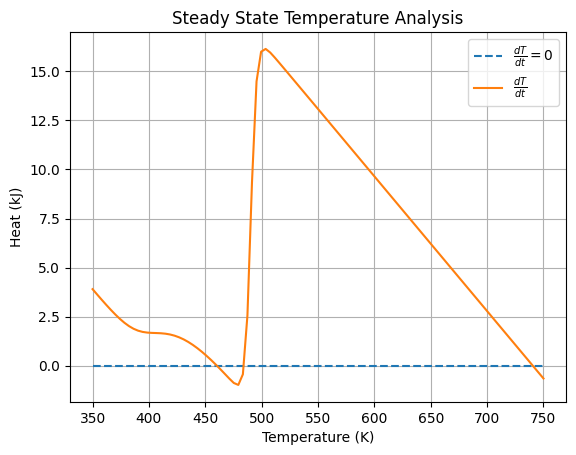

T_s = 460.31823156995324 K
C_A steady state = 0.21167013796294581 mol/L 
C_S steady state = 2.9999920948240835 mol/L


In [249]:
# params
k_10 = 4e14
E_1 = 1.28e5  
k_20 = 1e84
E_2 = 8e5
H_1 = -45400e-3
H_2 = -3.2e2
rho = 12.4
C_p = 254e-3
A = 5.3
T_c = 373
V = 4000

F_A0 = 1075
F_S0 = 750
F_B0 = 1275

F = F_A0 + F_B0 + F_S0

v_0 = F / rho
C_A0 = F_A0 / v_0
C_B0 = F_B0 / v_0
C_S0 = F_S0 / v_0

U_s = 14.656
T_0s = 410

R = 8.314

# define symbolic state space equations
C_A, C_S, T, T_0, U = symbols('C_A, C_S, T, T_0, U')

k_1 = k_10 * exp(-E_1 / T / R)
k_2 = k_20 * exp(-E_2 / T / R)

f_C_A = v_0 / V * (C_A0 - C_A) - k_1 * C_A * (C_A + C_B0 - C_A0)

f_C_S = v_0 / V * (C_S0 - C_S) - k_2 * C_S

f_T = v_0 / V * (T_0 - T) + (-H_1 * k_1 * C_A * (C_A + C_B0 - C_A0) - H_2 * k_2 * C_S) / (rho * C_p) - (U * A * (T - T_c)) / (V * rho * C_p)

# Evaluate steady states

# functions
def solve_C_A(_T):
    _f = lambdify(C_A, f_C_A.subs({T: _T}), 'numpy')
    _C_A = fsolve(_f, [4])

    return _C_A[0]

def solve_C_S(_T):
    _f = lambdify(C_S, f_C_S.subs({T: _T}), 'numpy')
    _C_S = fsolve(_f, [4])

    return _C_S[0]

def solve_heat(x):
    _T = x[0]
    _C_A = solve_C_A(_T)
    _C_S = solve_C_S(_T)
    __f = f_T.subs({C_A: _C_A, C_S: _C_S, T_0: T_0s, U: U_s})
    _f = lambdify(T, __f, 'numpy')
    return [_f(_T)]

# Steady state temperature analysis
T_range = np.linspace(350, 750, 100)

energy_balance = np.zeros(T_range.shape[0])

plt.plot(T_range, energy_balance, '--', label=r"$\frac{dT}{dt}=0$")

for i, val in enumerate(T_range):
    energy_balance[i] = solve_heat([val])[0]

plt.plot(T_range, energy_balance, label=r"$\frac{dT}{dt}$")
plt.title("Steady State Temperature Analysis")
plt.xlabel("Temperature (K)")
plt.ylabel("Heat (kJ)")
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

# T_s evaluation
T_s = fsolve(solve_heat, [460])[0]

print(f"T_s = {T_s} K")

# steady state outlet
C_As = solve_C_A(T_s)
C_Ss = solve_C_S(T_s)
print(f"C_A steady state = {C_As} mol/L \nC_S steady state = {C_Ss} mol/L")

## Problem 3

In [252]:
# conversion
print(f"Steady state conversion of A = {1 - C_As / C_A0}")
print(f"Steady state conversion of S = {1 - C_Ss / C_S0}")

Steady state conversion of A = 0.9507743865202452
Steady state conversion of S = 2.6350586388446118e-06


# Problem 4

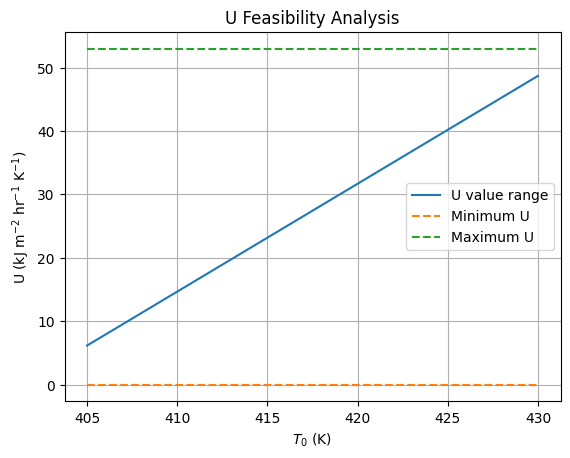

Largest T_0 = 432.53630992886247 K


In [280]:
U_of_T_0 = solve(Eq(0, f_T.subs({C_A: C_As, C_S: C_Ss, T: T_s})), U)

U_of_T_0 = lambdify(T_0, U_of_T_0[0], 'numpy')

T_0_range = np.linspace(410-5, 410+20, 100)

plt.plot(T_0_range, U_of_T_0(T_0_range), label="U value range")
plt.plot(T_0_range, np.zeros(T_0_range.shape[0]), '--', label="Minimum U")
plt.plot(T_0_range, 53*np.ones(T_0_range.shape[0]), '--', label="Maximum U")
plt.xlabel(r"$T_0$ (K)")
plt.ylabel(r"U (kJ m$^{-2}$ hr$^{-1}$ K$^{-1}$)")
plt.legend()
plt.grid(which='both', axis='both')
plt.title("U Feasibility Analysis")
plt.show()

largest_T_0 = fsolve(lambda T: U_of_T_0(T) - 53, [430])[0]
print(f"Largest T_0 = {largest_T_0} K")

# Problem 5

In [257]:
# matrices around U
A = sympy.matrices.Matrix([
    [
        f_C_A.diff(C_A).subs({C_A: C_As, T: T_s}), 
        f_C_A.diff(C_S).subs({C_A: C_As, T: T_s}), 
        f_C_A.diff(T).subs({C_A: C_As, T: T_s}),
    ],
    [
        f_C_S.diff(C_A).subs({C_S: C_Ss, T: T_s}), 
        f_C_S.diff(C_S).subs({C_S: C_Ss, T: T_s}), 
        f_C_S.diff(T).subs({C_S: C_Ss, T: T_s}),
    ],
    [
        f_T.diff(C_A).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s}), 
        f_T.diff(C_S).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s}), 
        f_T.diff(T).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s}),
    ],
])

b_around_U = sympy.matrices.Matrix([
    [f_C_A.diff(U).subs({C_A: C_As, T: T_s})],
    [f_C_S.diff(U).subs({C_S: C_Ss, T: T_s})],
    [f_T.diff(U).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s})],

])

c = sympy.matrices.Matrix([
    [0, 0, 1],
])

d = 0

# matrices around T_0
b_around_T_0 = sympy.matrices.Matrix([
    [f_C_A.diff(T_0).subs({C_A: C_As, T: T_s})],
    [f_C_S.diff(T_0).subs({C_S: C_Ss, T: T_s})],
    [f_T.diff(T_0).subs({C_A: C_As, C_S: C_Ss, T: T_s, U: U_s, T_0: T_0s})],

])

In [258]:
A

Matrix([
[-1.5222372710907,                   0, -0.0185656237024398],
[               0, -0.0625001646915989, -2.2436503160448e-7],
[21.0414249769869, 1.67326999164616e-5,    0.19897190528984]])

In [259]:
b_around_U

Matrix([
[                  0],
[                  0],
[-0.0367337620111087]])

In [260]:
b_around_T_0

Matrix([
[     0],
[     0],
[0.0625]])

In [261]:
c

Matrix([[0, 0, 1]])

In [12]:
system_parameter_dict = {
    'parameters': {
        'k_10': k_10,
        'E_1': E_1,  
        'k_20': k_20,
        'E_2': E_2,
        'H_1': H_1,
        'H_2': H_2,
        'rho': rho,
        'C_p': C_p,
        'A': 5.3,
        'T_c': T_c,
        'V': V,
    },
    'inlet': {
        'F_A0': F_A0,
        'F_S0': F_S0,
        'F_B0': F_B0,
        'F': F,
        'v_0': v_0,
        'C_A0': C_A0, 
        'C_B0': C_B0, 
        'C_S0': C_S0, 
    },
    'steady_state': {
        'T_0': T_0s,
        'U': U_s,
        'T': T_s,
        'C_A': C_As,
        'C_S': C_Ss,
    },
    'state_space': {
        'around_U':{
            'A': np.array(A, dtype=float).tolist(),
            'b': np.array(b_around_U, dtype=float).tolist(),
            'c': np.array(c, dtype=float).tolist(),
            'd': d,
        },
        'around_T_0': {
            'A': np.array(A, dtype=float).tolist(),
            'b': np.array(b_around_T_0, dtype=float).tolist(),
            'c': np.array(c, dtype=float).tolist(),
            'd': d,
        }
    }
}

# Problem 10 Stability Analysis

Offset:

$T(s)=\frac{G_cG_p}{1+G_cG_p}T_{sp}+\frac{G_w}{1+G_cG_p}T_0$

Disturbance:

$G(s)=\frac{G_w}{1+G_cG_p}$

Offset:

offset $=0-\lim_{s\rightarrow 0}MG(s)=-M\lim_{s\rightarrow 0}\frac{G_w}{1+G_cG_p}$

offset $=-\frac{Mk_w}{1+k_ck_p}$

Routh analysis around P only controller

In [262]:
G_w = (0.0625 * s + 0.09514) / (s**2 + 1.323 * s + 0.08776)
G_p = (-0.03673 * s - 0.05592) / (s**2 + 1.323 * s + 0.08776)

k_c, k_I = symbols("k_c, k_I")

In [265]:
G_c = k_c
G = simplify(G_w / (1 + G_c * G_p))
den = expand(sympy.parsing.sympy_parser.parse_expr(str(G).split("/")[1]))

a_0 = den.coeff(s**2)
a_1 = den.coeff(s)
a_2 = simplify(den - a_0 * s**2 - a_1 * s)
B_1 = a_2

In [266]:
solve(a_1 > 0, k_c)

(36.0196025047645 < k_c) & (k_c < oo)

In [267]:
solve(B_1 > 0, k_c)

(1.56938483547926 < k_c) & (k_c < oo)

# Problem 11 Stability Analysis

In [268]:
G_c = k_c * (1 + k_I / s)
G = simplify(G_w / (1 + G_c * G_p))
den = expand(sympy.parsing.sympy_parser.parse_expr(str(G).split("/")[1]))

In [269]:
a_0 = den.coeff(s**3)
a_1 = den.coeff(s**2)
a_2 = den.coeff(s)
a_3 = simplify(den - a_0 * s**3 - a_1 * s**2 - a_2 * s)

B_1 = simplify((a_1 * a_2 - a_0 * a_3) / a_1)
C_1 = a_3

In [270]:
solve(a_1 > 0, k_c)

(36.0196025047645 < k_c) & (k_c < oo)

In [271]:
(solve(simplify(B_1 * sympy.parsing.sympy_parser.parse_expr(str(B_1).split("/")[1])) > 0, k_I))

k_I*k_c*(0.0013490929*k_c + 0.00732621) > -0.0020539416*k_c**2 + 0.0772055848*k_c - 0.11610648

In [272]:
solve(C_1 > 0, k_I)

0.05592*k_I*k_c > 0

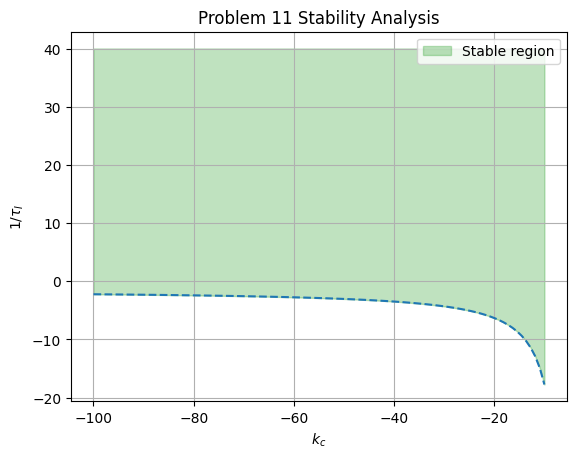

In [285]:
ineq = lambda k_c: (-0.0020539416*k_c**2 + 0.0772055848*k_c - 0.11610648) / (k_c*(0.0013490929*k_c + 0.00732621))

vals = np.linspace(-100, -10, 100)

plt.plot(vals, ineq(vals), "--")
plt.fill_between(vals, ineq(vals), 40, color="tab:green", alpha=0.3, label="Stable region")
plt.grid(which="both", axis="both")
plt.legend()
plt.xlabel(r"$k_c$")
plt.ylabel(r"$1/\tau_I$")
plt.title("Problem 11 Stability Analysis")
plt.show()